# Fundamentos de analítica 2 (clase 2)

## Diego Fernando Agudelo 
## Universidad ICESI 
## diegoagudelo30@gmail.com

## **1. Carga de paquetes**

In [132]:
import pandas as pd
import numpy as np 
from statsmodels.sandbox.stats.runs import runstest_1samp # prueba de rachas de Wald y Wolfowitz
import statsmodels.api as sm # prueba de Box-Pierce y la modificación de Ljung-Box
from matplotlib import pyplot as plt # gráficos 
import pylab as py
from scipy import stats
from datetime import datetime
from dateutil.relativedelta import relativedelta
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import itertools
import seaborn as sns
from scipy.stats import jarque_bera, shapiro
from statsmodels.stats.diagnostic import acorr_ljungbox
from pandas.tseries.offsets import MonthBegin

## **2. Carga de datos**

Vamos a usar los datos del libro para hacer las diferentes pruebas.

In [133]:
data = pd.read_excel(r'https://github.com/alfa7g7/Fundamentos-analitica-II/raw/main/Clase%201/Ejercicio%20en%20clase.-20240802/datosEmpleo.xlsx', index_col='mes', parse_dates=True)
data.head()

,TD_13ciudades,Ocupados,Desocupados,Inactivos
mes,,,,
2001-01-01,20.946380,6923.604,1834.507,4600.718
2001-02-01,19.894213,7037.746,1747.820,4596.805
2001-03-01,19.221565,6945.973,1652.823,4807.120
2001-04-01,17.888575,6973.079,1519.137,4937.280
2001-05-01,17.945654,6994.462,1529.720,4928.911


(220, 4)


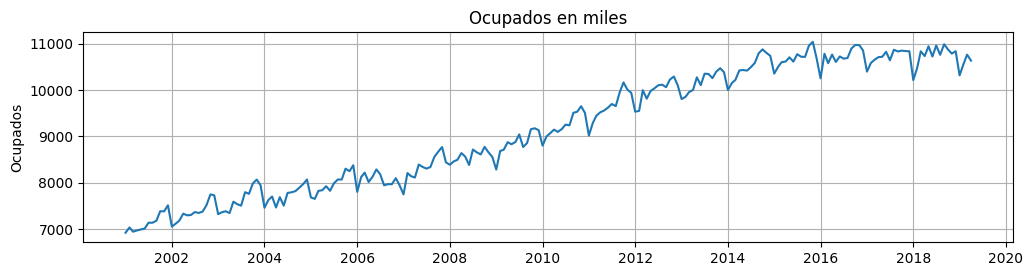

In [134]:
# imprimiendo el tamano del dataframe
print(data.shape)

# Graficando los datos
fig = plt.figure(figsize=(12, 6))

plt.subplot(2,1, 1)
plt.title("Ocupados en miles")
plt.ylabel("Ocupados")
plt.plot(data[["Ocupados"]])
plt.grid()
plt.show()

In [135]:
# Genero los dummies de los meses para poder realizar posteriormente los diferentes protocoloes de evaluación sin inconvenientes

month_dummies = pd.get_dummies(data.index.month, drop_first=True).set_index(data.index)
month_dummies = month_dummies.astype(float) # para arreglar el problema de casteo
month_dummies = pd.concat([data, month_dummies], axis=1)# Añadir las variables dummy al final del DataFrame original
month_dummies

,TD_13ciudades,Ocupados,Desocupados,Inactivos,2,3,4,5,6,7,8,9,10,11,12
mes,,,,,,,,,,,,,,,
2001-01-01,20.946380,6923.604,1834.507,4600.718,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2001-02-01,19.894213,7037.746,1747.820,4596.805,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2001-03-01,19.221565,6945.973,1652.823,4807.120,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2001-04-01,17.888575,6973.079,1519.137,4937.280,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2001-05-01,17.945654,6994.462,1529.720,4928.911,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-01,10.725865,10835.398,1301.822,6142.856,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2019-01-01,13.739328,10314.438,1642.851,6343.066,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-02-01,12.427409,10557.917,1498.272,6264.403,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## **3. Protocolo de evaluación**

Definimos nuestro conjunto de entramiento y pruebas

In [136]:
# Separar los datos en entrenamiento y prueba
horizon = 6 # El numero de pronósitco que queremos hacer hacia el futuro
train_len = len(month_dummies)- horizon
train_data = month_dummies.iloc[:train_len]
test_data = month_dummies.iloc[train_len:]

In [137]:
train_data

,TD_13ciudades,Ocupados,Desocupados,Inactivos,2,3,4,5,6,7,8,9,10,11,12
mes,,,,,,,,,,,,,,,
2001-01-01,20.946380,6923.604,1834.507,4600.718,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2001-02-01,19.894213,7037.746,1747.820,4596.805,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2001-03-01,19.221565,6945.973,1652.823,4807.120,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2001-04-01,17.888575,6973.079,1519.137,4937.280,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2001-05-01,17.945654,6994.462,1529.720,4928.911,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-06-01,11.071347,10720.946,1334.725,6101.948,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-07-01,10.125100,10959.197,1234.638,5984.340,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2018-08-01,10.085244,10756.782,1206.529,6235.352,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [138]:
test_data

,TD_13ciudades,Ocupados,Desocupados,Inactivos,2,3,4,5,6,7,8,9,10,11,12
mes,,,,,,,,,,,,,,,
2018-11-01,9.844539,10783.299,1177.484,6298.992,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2018-12-01,10.725865,10835.398,1301.822,6142.856,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2019-01-01,13.739328,10314.438,1642.851,6343.066,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-02-01,12.427409,10557.917,1498.272,6264.403,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-03-01,11.975098,10760.776,1463.919,6116.140,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-04-01,11.144286,10632.028,1333.469,6395.575,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


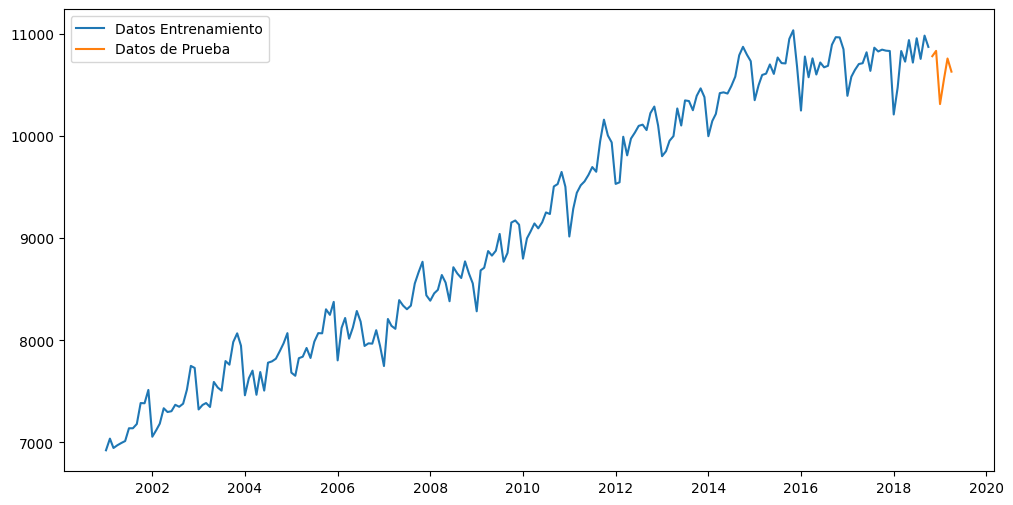

In [139]:
fig = plt.figure(figsize=(12, 6))
plt.plot(train_data["Ocupados"],label="Datos Entrenamiento")
plt.plot(test_data["Ocupados"],label="Datos de Prueba")
plt.legend()
plt.show()

## **4. Modelación**

In [140]:
# Inicializar una lista para almacenar los resultados
rmse_results = []

for orden in range(1, 8):
    # Modelo sin estacionalidad
    y_train = train_data["Ocupados"]
    x_train = np.linspace(1, train_data.shape[0], train_data.shape[0])
    X_train = np.vander(x_train, N=orden+1)
    
    lin = sm.OLS(y_train, X_train)
    lin_t = lin.fit()

    y_test = test_data["Ocupados"]
    x_test = np.linspace(len(train_data) + 1, len(data), len(test_data))
    X_test = np.vander(x_test, N=orden+1)

    y_pred = lin_t.predict(X_test)
    rmse_sin_estacionalidad = np.sqrt(mean_squared_error(y_test, y_pred))

    # Modelo con estacionalidad
    X_train_season = np.concatenate([X_train, train_data.iloc[:, 4:].values], axis=1)
    lin_season = sm.OLS(y_train, X_train_season)
    lin_t_season = lin_season.fit()

    X_test_season = np.concatenate([X_test, test_data.iloc[:, 4:].values], axis=1)
    y_pred_season = lin_t_season.predict(X_test_season)
    rmse_con_estacionalidad = np.sqrt(mean_squared_error(y_test, y_pred_season))

    # Almacenar los resultados en la lista
    rmse_results.append({'orden': orden, 'sin Estacionalidad': rmse_sin_estacionalidad, 'con Estacionalidad': rmse_con_estacionalidad})

# Convertir el conjunto de datos de resultados en un DataFrame
rmse_results_df = pd.DataFrame(rmse_results)

# Mostrar conjunto de datos de resultados
rmse_results_df

,orden,sin Estacionalidad,con Estacionalidad
0,1,718.651675,657.508980
1,2,646.597813,590.479496
2,3,238.469108,130.743939
3,4,222.843611,221.621692
4,5,219.947167,91.006689
5,6,337.129999,225.178930
6,7,3709.346672,3709.348872


Después del orden 7 e incluyendo este mismo, se empieza a perder poder de predicción aumentando así el rmse constantemente con cada orden siguiente, por ende para el ejercicio académico lo dejamos hasta orden 7.

Evaluando el resutlado obtenido el mejor modelo obtenido sería uno de orden 5 que también incluya la estacionalidad.

In [141]:
# Best model, orden 5 con estacionalidad
orden = 5

# Preparar las variables para el modelo
y_train = train_data["Ocupados"]
x_train = np.linspace(1, train_data.shape[0], train_data.shape[0])
X_train = np.vander(x_train, N=orden+1)

# Añadir las variables dummy (estacionalidad)
X_train_season = np.concatenate([X_train, train_data.iloc[:, 4:].values], axis=1)

# Ajustar el modelo de regresión lineal polinómico con estacionalidad
lin_season = sm.OLS(y_train, X_train_season)
lin_t_season = lin_season.fit()

print(lin_t_season.summary())

                            OLS Regression Results                            
Dep. Variable:               Ocupados   R-squared:                       0.992
Model:                            OLS   Adj. R-squared:                  0.991
Method:                 Least Squares   F-statistic:                     1447.
Date:                Mon, 12 Aug 2024   Prob (F-statistic):          1.19e-194
Time:                        20:37:38   Log-Likelihood:                -1324.0
No. Observations:                 214   AIC:                             2682.
Df Residuals:                     197   BIC:                             2739.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1          8.625e-08   1.57e-08      5.499      0.0

In [142]:
# Preparar los datos de prueba
y_test = test_data["Ocupados"]
x_test = np.linspace(len(train_data) + 1, len(data), len(test_data))
X_test = np.vander(x_test, N=orden+1)
X_test_season = np.concatenate([X_test, test_data.iloc[:, 4:].values], axis=1)

# Obtener los coeficientes (betas) del modelo
betas = lin_t_season.params

# Mostrar los betas
print("Coeficientes del modelo (Betas):")
print(betas)

Coeficientes del modelo (Betas):
x1       8.625089e-08
x2      -5.370993e-05
x3       1.120143e-02
x4      -8.958470e-01
x5       4.223479e+01
const    6.588641e+03
x6       1.712018e+02
x7       2.353168e+02
x8       2.374569e+02
x9       2.967677e+02
x10      2.555894e+02
x11      3.310670e+02
x12      3.052980e+02
x13      3.643789e+02
x14      4.742364e+02
x15      4.924690e+02
x16      3.906222e+02
dtype: float64


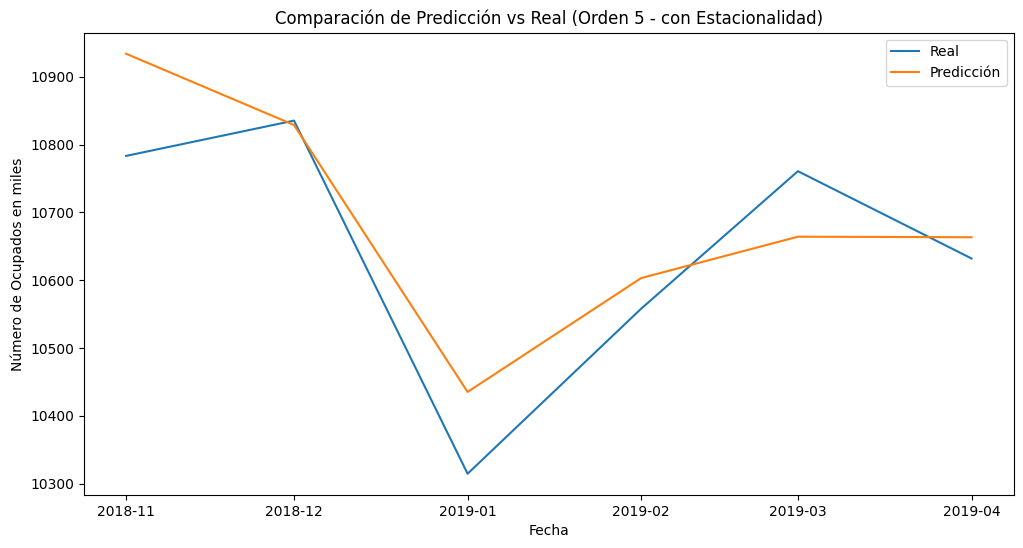

In [143]:
# Realizar la predicción
y_pred_season = lin_t_season.predict(X_test_season)

# Gráfico de Predicción vs Real
plt.figure(figsize=(12, 6))
plt.plot(test_data.index, y_test, label='Real')
plt.plot(test_data.index, y_pred_season, label='Predicción')
plt.title('Comparación de Predicción vs Real (Orden 5 - con Estacionalidad)')
plt.xlabel('Fecha')
plt.ylabel('Número de Ocupados en miles')
plt.legend()
plt.show()

            Ocupados   Predicción
mes                              
2001-01-01  6923.604  6629.991243
2001-02-01  7037.746  6840.817935
2001-03-01  6945.973  6942.897760
2001-04-01  6973.079  6981.406827
2001-05-01  6994.462  7075.553469


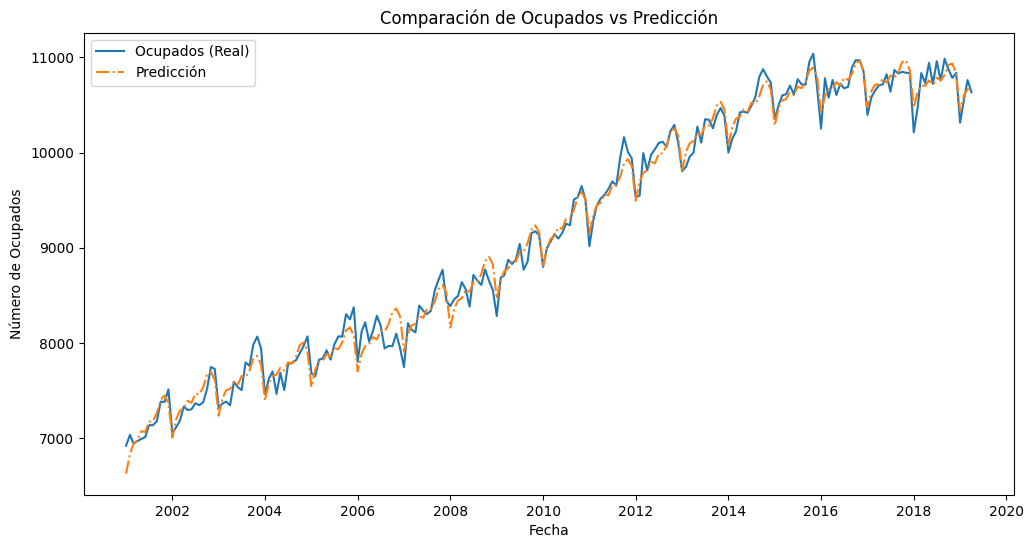

In [144]:
# Preparar las variables para todo el dataset (220 datos)
x_full = np.linspace(1, len(month_dummies), len(month_dummies))
X_full = np.vander(x_full, N=orden+1)

# Añadir las variables dummy (estacionalidad)
X_full_season = np.concatenate([X_full, month_dummies.iloc[:, 4:].values], axis=1)

# Usar los betas para predecir los valores
y_pred_full = np.dot(X_full_season, betas)

# Añadir las predicciones al DataFrame original
month_dummies['Predicción'] = y_pred_full

# Mostrar las primeras filas del DataFrame con la predicción
print(month_dummies[['Ocupados', 'Predicción']].head())

# Generar el gráfico de "Ocupados" vs "Predicción"
plt.figure(figsize=(12, 6))
plt.plot(month_dummies.index, month_dummies['Ocupados'], label='Ocupados (Real)')
plt.plot(month_dummies.index, month_dummies['Predicción'], label='Predicción', linestyle='-.')
plt.title('Comparación de Ocupados vs Predicción')
plt.xlabel('Fecha')
plt.ylabel('Número de Ocupados')
plt.legend()
plt.show()

Por último realizamos la predicción de los 6 mese teniendo en cuenta todo el conjunto de datos y este mismo dumificado.

In [145]:
# Paso 1: Extender el dataset original para incluir los próximos 6 meses

# Obtener el índice del último mes del dataset original
start_date = data.index[-1] + MonthBegin(1)

# Generar las nuevas fechas, que serán el primer día de cada mes
new_dates = pd.date_range(start=start_date, periods=6, freq='MS')

# Crear un DataFrame vacío para las nuevas filas
new_data = pd.DataFrame(index=new_dates, columns=data.columns)

# Concatenar las nuevas filas al dataset original
data_extended = pd.concat([data, new_data])

# Paso 2: Dumificar las nuevas fechas

# Crear las variables dummy para todo el dataset extendido (incluyendo los nuevos meses)
month_dummies = pd.get_dummies(data_extended.index.month, drop_first=True).set_index(data_extended.index)
month_dummies = month_dummies.astype(float)

# Paso 3: Concatenar las dummies al dataset extendido
data_extended_with_dummies = pd.concat([data_extended, month_dummies], axis=1)

# Paso 4: Realizar la predicción utilizando el modelo ajustado

# Preparar las variables para la predicción futura
x_future = np.linspace(1, len(data_extended_with_dummies), len(data_extended_with_dummies))
X_future = np.vander(x_future, N=orden+1)

# Añadir las variables dummy (estacionalidad) a las variables futuras
X_future_season = np.concatenate([X_future, data_extended_with_dummies.iloc[:, 4:].values], axis=1)

# Usar los betas para predecir los valores futuros
y_pred_future = np.dot(X_future_season, betas)

# Añadir las predicciones al DataFrame extendido
data_extended_with_dummies['Predicción'] = y_pred_future

# Mostrar las primeras filas del DataFrame extendido con la predicción
print(data_extended_with_dummies[['Ocupados', 'Predicción']])

            Ocupados    Predicción
2001-01-01  6923.604   6629.991243
2001-02-01  7037.746   6840.817935
2001-03-01  6945.973   6942.897760
2001-04-01  6973.079   6981.406827
2001-05-01  6994.462   7075.553469
...              ...           ...
2019-06-01       NaN  10676.125441
2019-07-01       NaN  10749.267581
2019-08-01       NaN  10721.437533
2019-09-01       NaN  10778.769244
2019-10-01       NaN  10887.228117

[226 rows x 2 columns]


C:\Users\alfa7\AppData\Local\Temp\ipykernel_17484\3397922280.py:13: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data_extended = pd.concat([data, new_data])


### **5. Evaluación de los supuestos de los residuales**

Para poder hacer uso del modelo y los pronósticos se deben cumplir los supuestos del Teorema de Gauss-Markov sobre los residuales de un modelo de regresión múltiple.

- Probar **Autocorrelación** en los **residuales** con las pruebas Box-Pierce y Ljung-Box para los diferentes rezagos.

- Probar **Homoscedasticidad/Heteroscedasticidad** sobre los residuales, una aproximación para determinar si existe un comportamiento GARCH o ARCH es emplear la prueba de Ljung-Box sobre la serie (sin media) al cuadrado. En este caso al ser residuales de una regresión las series ya tienen media cero.

- Probar **Normalidad** sobre los residuales con las pruebas Jarque Bera y Shapiro-Wilk, adicionalmente se pueden realizar las graficas para ver el comportamiento de manera visual.

In [146]:
# Calcular los residuales
month_dummies['Residuals'] = month_dummies['Ocupados'] - month_dummies['Predicción']

# Graficar los residuales
plt.figure(figsize=(10, 6))
plt.plot(month_dummies.index, month_dummies['Residuals'], label='Residuals')
plt.title('Gráfico de los Residuales')
plt.xlabel('Fecha')
plt.ylabel('Residuals')
plt.axhline(y=0, linestyle='-.', color='orange')
plt.legend()
plt.show()

KeyError: 'Ocupados'

In [147]:
# Residuales del modelo
#residuals = lin_t_season.resid
residuals = month_dummies['Residuals']

# 1. Prueba de Autocorrelación: Box-Pierce y Ljung-Box
lb_test = acorr_ljungbox(residuals, lags=[10], return_df=True)
print("Prueba de Ljung-Box para Autocorrelación:")
print(lb_test)

# 2. Prueba de Homoscedasticidad: Ljung-Box sobre los residuales al cuadrado
residuals_squared = residuals ** 2
lb_test_squared = acorr_ljungbox(residuals_squared, lags=[10], return_df=True)
print("\nPrueba de Ljung-Box para Heterocedasticidad (residuales al cuadrado):")
print(lb_test_squared)

# 3. Prueba de Normalidad: Jarque-Bera y Shapiro-Wilk
jb_test = jarque_bera(residuals)
shapiro_test = shapiro(residuals)

print("\nPrueba de Jarque-Bera para Normalidad:")
print(f"Estadístico: {jb_test[0]}, p-valor: {jb_test[1]}")
print("Prueba de Shapiro-Wilk para Normalidad:")
print(f"Estadístico: {shapiro_test[0]}, p-valor: {shapiro_test[1]}")

# Visualizaciones para inspección visual de la normalidad
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Histograma de los residuales
sns.histplot(residuals, kde=True, ax=axs[0])
axs[0].set_title('Histograma de los Residuales')

# Gráfico Q-Q
sm.qqplot(residuals, line='s', ax=axs[1])
axs[1].set_title('Gráfico Q-Q de los Residuales')

plt.tight_layout()
plt.show()

KeyError: 'Residuals'

### **12. Ejercicio en Clase**

Empleando la información del número de ocupados en miles de personas (Ocupados) para las 13 principales ciudades, encuentre el mejor pronóstico para los próximos 6 meses empleando los métodos vistos en la clase. Compare
los resultados con el mejor modelo encontrado en el ejercicio anterior. 

Escriba un breve informe de máximo una página de texto que explique cómo llega a sus proyeccciones y presente las proyecciones. Aclare en el texto cuáles serían las limitaciones de sus pronósticos.